# Modèles de distributions d'espèces - Cas des forets urbaines à Montreal

## 1 - Introduction 
Le but de ce projet est de trouver un moyen de prédire efficacement la distribution des différentes espèces d'arbres à travers la région de Montreal, ce qui permetterait aux aménagistes forestiers de s'assurer que les espèces plantées survivent au changement climatique de la région. Ce projet se concentre particulièrement sur les **forets urbaines**.

Il sera alors question dans ce notebook de fournir le code capable de créer un **modèle de distribution d'espèces (SDM)** en utilisant des algorithmes **d'apprentissage automatique (Machine Learning)** avec le langage **R**.

## 2 - Collecte et traitement des données 
Pour créer un modèle de distribution d'espèces, on aura besoin de deux types de données : 
* **Les données d'occurrence :** Ces données relatent l'observation d'une espèce à une localisation (et/ou une date) précise. Ces données peuvent décrire le nombre d'une espèce dans chaque zone, on parlera alors de données *d'abondance*, sinon elles peuvent aussi seulement décrire la *présence et l'absence confirmée* d'une espèce dans la zone. Généralement, même les données contenant des absences confirmées sont rares car elles sont difficiles à produire. Nous trouverons alors plutôt des données *de présence seulement (presence-only data)*, et c'est cela que l'on va utiliser dans ce projet.


* **Les données environnementales :** Ces données relatent le climat d'une région donnée en le décrivant avec plusieurs variables environnementales (température annuelle minimale, précipitation maximale par saison...etc.). Ces données séparent généralement la région en plusieurs cellules à la manière d'une grille où chaque cellule contient des valeurs environnementales différentes. 

### 2.1 - Données d'occurrence :
Les données d'occurrence utilisées ici seront les données d'arbres publics à Montreal (voir ce lien : https://donnees.montreal.ca/ville-de-montreal/arbres (Consulté le 03/04/2021)). 

In [1]:
# Décommenter cette ligne pour installer le package BlockCV (introuvable sur Anaconda)
# install.packages('blockCV')

In [2]:
# Importer les bibliothèques nécessaires 

# Tidyverse : une bibliothèque populaire de manipulation de données
# Elle contient plusieurs autres packages telles que dplyr, readr, ggplot...etc.
library('tidyverse')

# Sp : Fournit des classes et des méthodes permettant de représenter et manipuler les données géospatiales
library('sp')

# Raster : Api haut niveau permettant la lecture / la manipulation des données raster et vecteurs
library('raster')

# RandomForest : Permet la création d'un modèle Random Forest
library('randomForest')

# RGDAL : Implementation Haut niveau de la bibliothèque publique GDAL
library('rgdal')

# Caret : Bibliothèque d'évalation des modèles de Machine Learning
library('caret')

# Conflicted : Affiche les conflits entre les packages si il y en a (lors de l'appel d'une fonction par exemple)
library('conflicted')

# Rgeos : Est utilisée ici pour créer des polygones utiles à la génération de données de pseudo-absence
library('rgeos')

# BlockCV : Permet la séparation des données de test/entrainement en utilsant la Block Cross Validation
library('blockCV')

# Dismo : Bibliothèque très populaire permettant d'implémenter des fonctions et des modèles associés aux SDMs
library('dismo')

# ROCR : Bibliothèque de génération des courbes ROC
library('ROCR')

# Corrplot : Afficher les matrices de corrélation
library('corrplot')

# Options de visualisation de dataframes : limiter le nombre de lignes et afficher un maximum de colonnes
options(repr.matrix.max.cols=50, repr.matrix.max.rows=20)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Attaching package: 'raster'

The following object is masked from 'package:dplyr':

    select

The following object is masked from 'package:tidyr':

    extract

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:dplyr':

    combine

The following object is mas

In [3]:
# Lecture du fichier CSV
occurrence_data_raw <- read_csv('./data/arbres-publics.csv')

# Affichage du résultat
summary(occurrence_data_raw)

Parsed with column specification:
cols(
  .default = col_character(),
  EMP_NO = col_double(),
  ARROND = col_double(),
  Rue = col_logical(),
  COTE = col_logical(),
  No_civique = col_logical(),
  Coord_X = col_double(),
  Coord_Y = col_double(),
  DHP = col_double(),
  Date_releve = col_datetime(format = ""),
  Date_plantation = col_datetime(format = ""),
  LOCALISATION = col_logical(),
  Longitude = col_double(),
  Latitude = col_double()
)
See spec(...) for full column specifications.
Warning message:
"819326 parsing failures.
  row          col           expected                                           actual                        file
99669 Rue          1/0/T/F/TRUE/FALSE Avenue AdhÃ©mar-Mailhiot                         './data/arbres-publics.csv'
99669 COTE         1/0/T/F/TRUE/FALSE E                                                './data/arbres-publics.csv'
99669 No_civique   1/0/T/F/TRUE/FALSE 12323                                            './data/arbres-publics.csv'
99

   INV_TYPE             EMP_NO           ARROND       ARROND_NOM       
 Length:318077      Min.   :     2   Min.   : 1.00   Length:318077     
 Class :character   1st Qu.: 52512   1st Qu.: 3.00   Class :character  
 Mode  :character   Median :102232   Median : 7.00   Mode  :character  
                    Mean   :119664   Mean   : 8.89                     
                    3rd Qu.:179657   3rd Qu.:12.00                     
                    Max.   :447625   Max.   :33.00                     
                                                                       
   Rue            COTE         No_civique      Emplacement       
 Mode:logical   Mode:logical   Mode :logical   Length:318077     
 NA's:318077    NA's:318077    FALSE:6876      Class :character  
                               TRUE :95        Mode  :character  
                               NA's :311106                      
                                                                 
                            

Nous ne voulons garder que les informations les plus importantes. Ici ces informations sont l'espèce (le nom latin car il est plus précis), la Latitude, la Longitude et la valeur cible (la classe).

On crée la classe nous-mêmes. Ici la classe sera l'attribut "present" qui représente la présence d'une espèce. Elle sera initialisée à 1 pour tous les enregistrements.

In [4]:
# Création de la classe 
occurrence_data_raw$Present <- 1

# Selection des attributs pertinents
occurrence_data <- occurrence_data_raw %>% dplyr::select('Essence_latin', 'Latitude', 'Longitude', 'Present')

In [5]:
occurrence_data

Essence_latin,Latitude,Longitude,Present
Gleditsia triacanthos 'Skyline',45.53515,-73.71551,1
Gleditsia triacanthos 'Skyline',45.53522,-73.71559,1
Gymnocladus dioicus,45.53511,-73.71566,1
Fraxinus nigra 'Fall Gold',45.53562,-73.71530,1
Quercus rubra,45.53560,-73.71560,1
Quercus macrocarpa,45.53582,-73.71571,1
Acer saccharinum 'Montréal',45.53582,-73.71536,1
Acer platanoides 'Emerald Queen',45.53619,-73.71556,1
Thuja occidentalis 'Nigra',45.53635,-73.71555,1
Thuja occidentalis 'Nigra',45.53628,-73.71552,1


Il est maintenant temps de nettoyer nos données. 

Premièrement, on recherche les enregistrements avec des valeurs manquantes (dans les attributs pertinents) et on les enlève.
Puis on enlève les doublons dans les données si il y en a.

In [6]:
summary(occurrence_data)

 Essence_latin         Latitude          Longitude         Present 
 Length:318077      Min.   : 0.04566   Min.   :-77.36   Min.   :1  
 Class :character   1st Qu.:45.48524   1st Qu.:-73.64   1st Qu.:1  
 Mode  :character   Median :45.53187   Median :-73.60   Median :1  
                    Mean   :45.50730   Mean   :-73.61   Mean   :1  
                    3rd Qu.:45.56468   3rd Qu.:-73.57   3rd Qu.:1  
                    Max.   :72.35156   Max.   :-24.29   Max.   :1  
                    NA's   :4          NA's   :4                   

In [7]:
# ===== 1. Valeurs manquantes =======
before_count <- count(occurrence_data)
occurrence_data <- occurrence_data %>% dplyr::filter((!is.na(Longitude) | Longitude == 0) & !is.na(Latitude) & !is.na(Essence_latin))
after_count <- count(occurrence_data)

# Afficher le nombre de lignes supprimées
sprintf("Nombre de lignes avec valeurs manquantes enlevées : %d", before_count$n - after_count$n)

# ===== 2. Enregistrements doublons =======
before_count <- count(occurrence_data)
occurrence_data <- occurrence_data %>% dplyr::distinct()
after_count <- count(occurrence_data)

# Afficher le nombre de lignes supprimées
sprintf("Nombre de lignes doublons enlevées : %d", before_count$n - after_count$n)

[1] "Nombre de lignes avec valeurs manquantes enlevées : 4"

[1] "Nombre de lignes doublons enlevées : 1587"

**Note : Il sera aussi important de gérer l'autocorrelation spatiale**

Il est important à noter que cette base de données contient des enregistrements de plusieurs espèces différentes et les modèles de distribution d'espèces sont utilisées pour modéliser une espèce étudiée à la fois. Nous devons donc séparer les enregistrements par espèces.

**Note : dans cette première version, on va tester le modèle avec une seule espèce, à savoir l'espèce la plus présente dans les données :**

In [8]:
# !!!!!!!! CODE DE TEST !!!!!!!!!
# Identifier et tirer l'espèce la plus présente dans les données d'occurrence
species_counts <- occurrence_data %>% count(Essence_latin, sort=TRUE)
most_found_species <- slice(species_counts, 1)$Essence_latin
species_data <- occurrence_data %>% dplyr::filter(Essence_latin==most_found_species)
species_data

Essence_latin,Latitude,Longitude,Present
Acer saccharinum,45.54076,-73.69629,1
Acer saccharinum,45.54860,-73.65310,1
Acer saccharinum,45.54869,-73.65331,1
Acer saccharinum,45.54880,-73.65326,1
Acer saccharinum,45.53700,-73.71862,1
Acer saccharinum,45.53703,-73.71842,1
Acer saccharinum,45.52495,-73.71480,1
Acer saccharinum,45.54861,-73.63966,1
Acer saccharinum,45.55094,-73.63016,1
Acer saccharinum,45.57792,-73.64505,1


In [9]:
# Enlever le nom de l'espèce de la dataframe
species_data <- species_data %>% dplyr::select('Longitude', 'Latitude', 'Present')

Affichons ces données sur une carte, pour cela nous allons utiliser la fonction plot (dont le comportement change grâce à la bibliothèque "sf").

Nous allons avoir besoin aussi d'une carte du monde sur laquelle dessiner les points. Nous utilisons ici une carte de la ressource publique *Natural Earth* (ref : https://www.naturalearthdata.com/ (consulté le 06/04/2021)).

In [10]:
# Carte du monde avec les bordures des villes / provinces dans chaque pays 
world_map <- shapefile("data/natural_earth_vector/10m_cultural/ne_10m_admin_1_states_provinces.shp")

In [11]:
# Créer une fonction pour dessiner les points d'occurrence sur la carte du monde
plot_species_data_on_map <- function(species_data, background_map=world_map, plot_label="", 
                                     col="dark green", pch=20, cex=0.1, extent=NULL, ...){
    # Calculer l'extent si il est NULL
    # Ici l'extent est le "carré" entourant tous les points de notre dataset (minlong, maxlong, minlat, maxlat)
    if (is.null(extent)){
        # Si les données sont sous forme de SpatialPoints, 
        # utiliser la fonction extent pour extraire l'extent, sinon le calculer manuellement
        if (class(species_data) == 'SpatialPoints'){
            extent <- extent(species_data)
        } else{
            extent <- c(min(species_data$Longitude), max(species_data$Longitude), 
                min(species_data$Latitude), max(species_data$Latitude))
        }
    }
    
    # Reprojeter les données d'occurrence
    if (!is.na(crs(species_data))){
        species_data <- spTransform(species_data, crs(background_map))
    }
        
    # Afficher la carte background
    plot(background_map, xlim=c(extent[1], extent[2]), 
         ylim=c(extent[3], extent[4]), col="light gray", 
           xlab="longitude", ylab="latitude", main=plot_label)
    
    # Dessiner les points sur la carte
    if (class(species_data) == 'SpatialPoints'){
        points(species_data, col=col, pch=pch, cex=cex)
    } else {
        points(species_data$Longitude, species_data$Latitude, col=col, pch=pch, cex=cex)
    }
    
    box()
}

Warning message in if (class(species_data) == "SpatialPoints") {:
"la condition a une longueur > 1 et seul le premier élément est utilisé"Warning message in if (class(x) == "character") {:
"la condition a une longueur > 1 et seul le premier élément est utilisé"Warning message in if (class(x) != "CRS") {:
"la condition a une longueur > 1 et seul le premier élément est utilisé"Warning message in if (class(species_data) == "SpatialPoints") {:
"la condition a une longueur > 1 et seul le premier élément est utilisé"

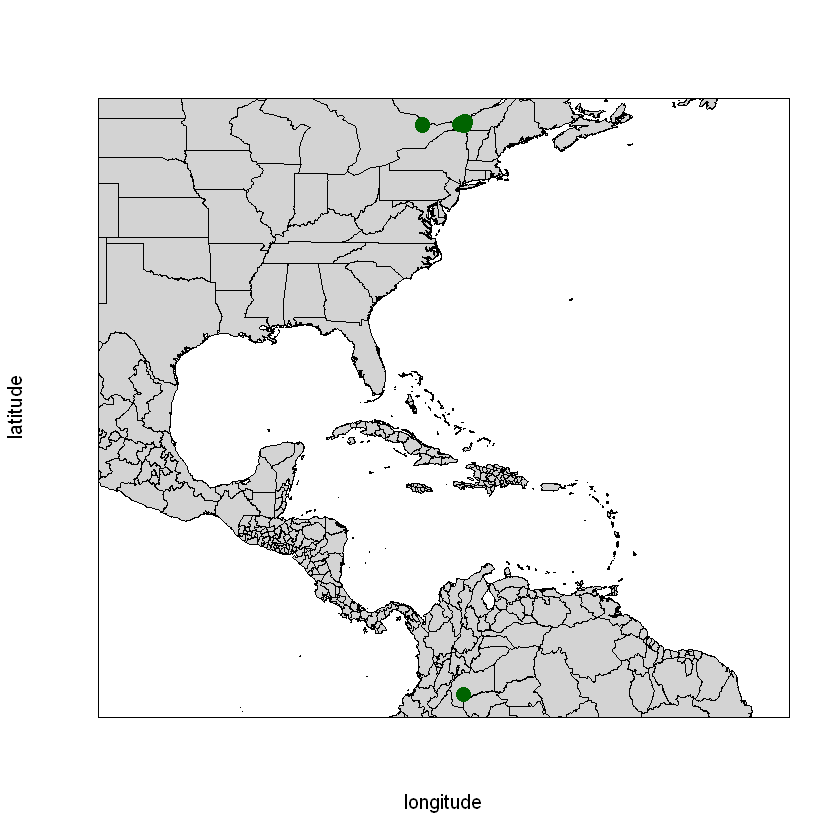

In [12]:
# Afficher la carte
plot_species_data_on_map(species_data, cex=2.5)

# Afficher un cadre entourant le graphe
box()

Nous pouvons remarquer que certains points (dont la taille est exagérée ici) ont des coordonnées incohérentes. Il se pourrait que ce soit une simple faute de frappe ou une autre erreur.

Avant de décider quoi faire pour ces données, nous allons devoir afficher ces données. Pour se faire nous allons utiliser une carte de Montreal plus précise. C'est la carte des limites administratives de la ville (trouvée dans ce lien https://donnees.montreal.ca/ville-de-montreal/polygones-arrondissements (consulté le 13/04/2021)) : 

In [13]:
# Charger la carte de Montreal (Limites administratives)
montreal_map <- shapefile('data/montreal/limadmin/LIMADMIN.shp')

# Obtenir le "carré" entourant la ville de Montreal (minlong, maxlong, minlat, maxlat)
montreal_boundaries <- extent(montreal_map)

# On considére les données comme étant des anomalies si ces données ne sont pas dans les limites de la ville
anomalies <- species_data %>% dplyr::filter((Longitude < montreal_boundaries[1]) | (Longitude > montreal_boundaries[2]) |
                                            (Latitude < montreal_boundaries[3]) | (Latitude > montreal_boundaries[4]))
anomalies

Longitude,Latitude,Present
-77.01614,45.497951,1
-73.63066,2.625368,1
-73.63056,2.625469,1
-77.01803,45.372684,1


Tant que le nombre de points est petit (les supprimer ne rend pas l'espèce sous-représentée), on peut juste les éliminer.

In [14]:
# Transformer les données d'occurrence en SpatialPointsDataFrame
species_data <- SpatialPointsDataFrame(data=species_data[3], coords=species_data[1:2])

# Filtrer les données incohérentes
species_data <- crop(species_data, montreal_boundaries)

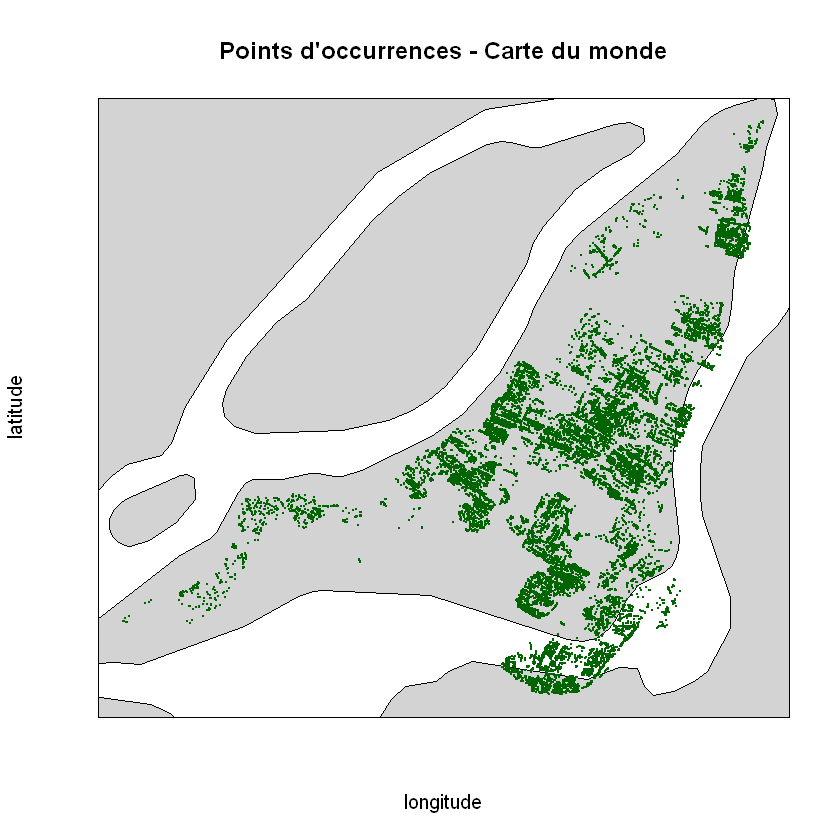

In [15]:
# Afficher les points sur la carte du monde
plot_species_data_on_map(species_data, plot_label="Points d'occurrences - Carte du monde")

Parfait, on voit maintenant que le points sont tous centrés autour de la ville de Montreal.

Mais ça dépasse. C'est clairement un problème de la carte du monde vu que l'on a vu que les points ne pouvaient pas dépasser les bordures de Montreal. Pour cette raison (entre autres), nous allons utiliser la carte de Montreal, qui est plus précise :

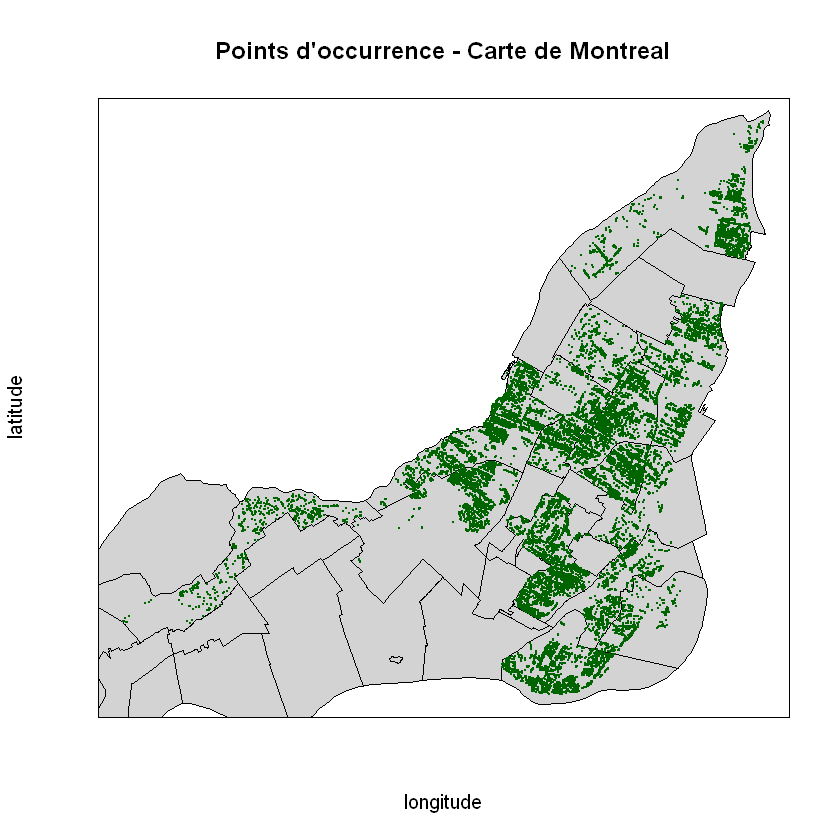

In [16]:
# Afficher les points sur la carte de Montreal
plot_species_data_on_map(species_data, background_map=montreal_map, plot_label="Points d'occurrence - Carte de Montreal")

### 2.2 - Génération des données d'absence
Comme dit plus tôt, les données que l'on utilise sont des données de présence seulement, nous devons alors générer des données d'absence.

Ici nous allons utiliser une technique très simple, nous allons prendre aléatoirement des données à des points situés autour des points de présence (à un rayon de 5 km) 

**Note : Cette technique a été vue dans ces deux ressources : https://rspatial.org/raster/sdm/3_sdm_absence-background.html et https://www.molecularecologist.com/2013/04/23/species-distribution-models-in-r/, mais je comprends bien qu'il faudra changer / mieux expliquer pourquoi c'est la meilleure technique si elle l'est vraiment**

Pour cela on utilise la bibliothèque **dismo** pour créer des cercles autour de chaque point, puis on echantillonne aléatoirement des points d'absences à partir de ces polygones :

In [17]:
# Definir une valeur de 'seed' pour que les résultats soient les mêmes à chaque tentative
set.seed(12)

# Créer les cercles et y echantionner des points aléatoires
circles_list <- circles(species_data, d=10000, lonlat=TRUE)
absence_data <- spsample(circles_list@polygons, length(species_data), type='random', iter=100)

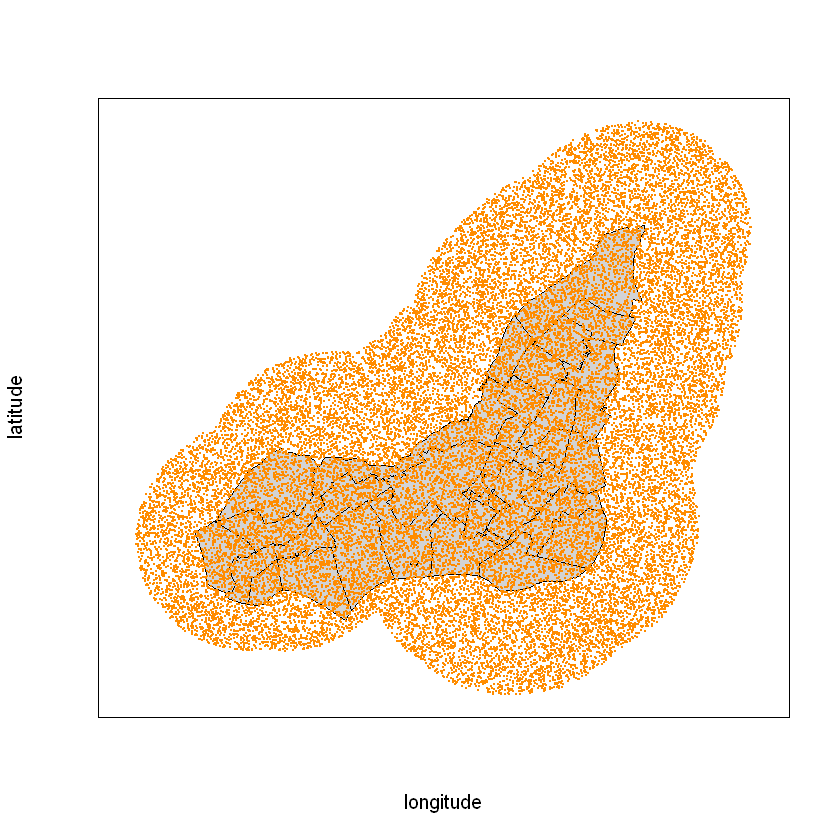

In [18]:
# Afficher les points d'absences sur la carte
plot_species_data_on_map(species_data=absence_data, background_map=montreal_map, col="dark orange")

Nous devons appliquer un masque pour ne créer des points que sur la surface terrestre de la ville de Montreal :

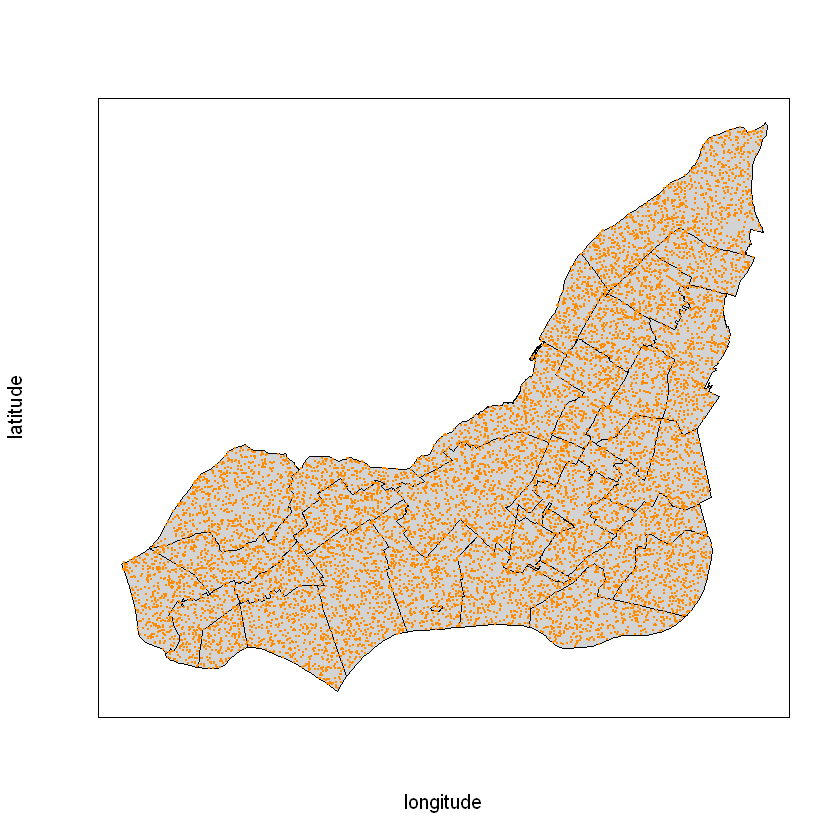

In [19]:
# Recentrer les points d'absence
absence_data <- spTransform(absence_data, crs(montreal_map))
absence_data_indexes <- over(absence_data, geometry(montreal_map))
absence_data <- absence_data[!is.na(absence_data_indexes), ]

# Afficher les points une seconde fois
plot_species_data_on_map(species_data=absence_data, background_map=montreal_map, col="dark orange")

Parfait, les points d'absence sont maintenant recentrés.

Maintenant, on combine les deux datasets ensemble pour obtenir nos données d'occurrences complètes :

In [20]:
# Transformer les données d'absence en SpatialPointsDataFrame (avec l'attribut Présent à 0)
absence_data <- SpatialPointsDataFrame(data = data.frame(Present = rep(0, length(absence_data))), coords=absence_data)

# Combiner les données d'absence et de présence
crs(absence_data) <- crs(species_data)
species_data <- rbind(species_data, absence_data)

### 2.3 - Données climatiques :

Pour les données climatiques, nous allons utiliser les données d'Ouranos (https://www.ouranos.ca/portraits-climatiques/#/regions/28 (consulté le 23/03/2021)).

Ces données contiennent des valeurs de plusieurs types de variables climatiques dans la région de Montreal.

Voici la liste complète des variables disponibles :

- Les températures moyennes quotidiennes (°C) (par an / par saisons)
- La moyenne des températures minimales quotidiennes (°C) (par an / par saisons)
- La moyenne des température maximales quotidiennes (°C) (par an / par saisons)
- Le degrés-jours de croissance (DJC) 
- Les événements de gel-dégel (jours)
- L’indice de gel (°C-jours)
- Le nombre de jours > 30°C (jours) 
- Le nombre de jours de vague de chaleur (jours) (3 Classes de seuil)
- Le nombre de vagues de chaleur (3 Classes de seuil)
- Les précipitations totales (mm) (par an / par saisons)
- Les précipitations liquides totales (mm) (par an / par saisons)
- Les précipitations solides totales (mm) (par an / par saisons)
- Le maximum des précipitations cumulées sur cinq jours (mm) (par an / de Avril à Septembre)

**Note : Le dataset a été converti du format .geoJSON au format .shp et les fichiers ont été renommés.**

Pour illustrer le processus d'extraction des variables environnementales, voici les étapes à suivre pour les **les températures moyennes quotidiennes** :

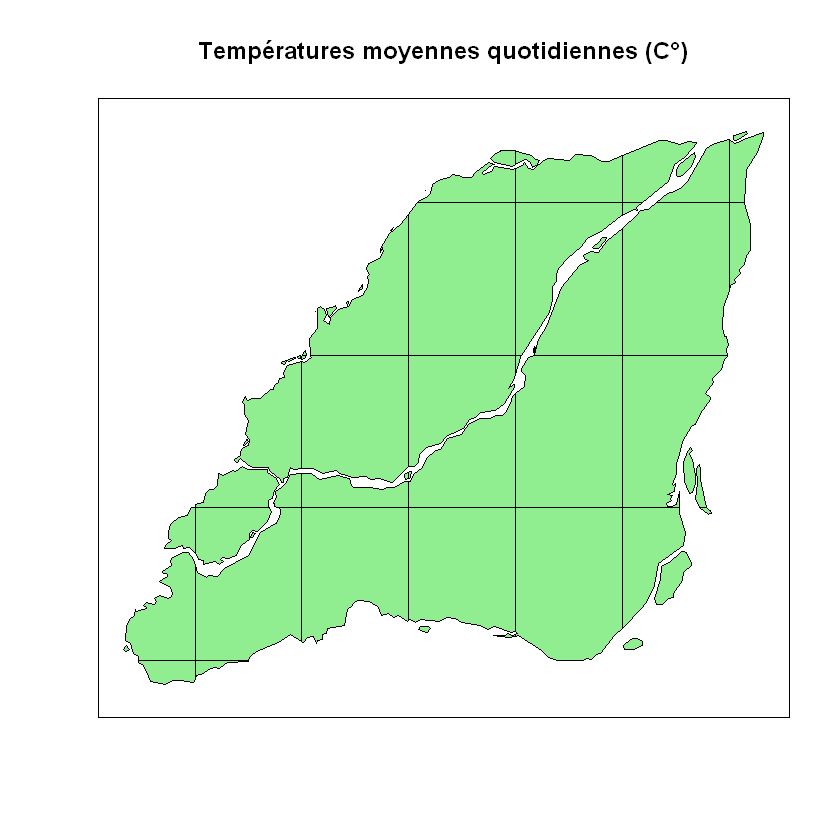

In [21]:
# Lire le fichier shapefile 
climate_vector <- shapefile('data/ouranos/mean_temp_year.shp')

# Afficher la figure sur une carte
plot(climate_vector, col="light green", main="Températures moyennes quotidiennes (C°)")
box()

Ce que l'on ne voit pas sur la carte, c'est que chaque polygone contient plusieurs valeurs d'attributs. 

On peut les visualiser, à la manière d'une data.frame : 

In [22]:
# Afficher les attributs pour chaque polygone
head(climate_vector@data)

,id,hist_1981_,rcp45_2041,rcp45_20_1,rcp45_20_2,rcp45_2071,rcp45_20_3,rcp45_20_4,rcp85_2041,rcp85_20_1,rcp85_20_2,rcp85_2071,rcp85_20_3,rcp85_20_4
0,"84,210",6.635,8.104,9.088,9.797,8.254,9.760,10.456,9.062,9.785,10.431,10.337,12.377,13.364
1,"84,211",6.752,8.221,9.204,9.904,8.371,9.880,10.562,9.180,9.906,10.544,10.456,12.492,13.469
2,"85,209",6.597,8.069,9.051,9.769,8.213,9.727,10.431,9.024,9.748,10.393,10.300,12.345,13.338
3,"85,210",6.740,8.207,9.191,9.899,8.352,9.869,10.560,9.159,9.890,10.529,10.435,12.482,13.464
4,"85,211",6.847,8.314,9.298,9.999,8.460,9.979,10.657,9.269,10.003,10.636,10.546,12.590,13.561
5,"86,208",6.499,7.975,8.955,9.682,8.112,9.634,10.348,8.938,9.653,10.300,10.214,12.257,13.254


L'attribut *hist_1981_* est celui qui contient la valeur de la variable étudiée (en l'occurrence la moyenne des températures quotidiennes) observée entre les années 1981 et 2010 (source : https://www.ouranos.ca/portraits-climatiques/#/regions/0).

Les attributs suivants (rcp45_2041, etc...) contiennent les valeurs prédites de la variable étudiée selon divers scénarii d'émissions de gaz, et ce entre les années 2041 et 2070, ainsi qu'entre les années 2071 et 2100.

Pour entrainer le modèle, nous avons besoin d'extraire l'attribut contenant la valeur observée. Notre objectif ici est de lier chaque point d'occurrence d'espèce avec la valeur de la variable environnementale observée à cet endroit. 

Nous pouvons alors utiliser la fonction **extract** du package **raster**, pour lier des données raster et nos données d'occurrence. Seul problème, nos données climatiques ne sont pas des données raster, ce sont des données vecteurs où les "grilles" sont dessinées par les polygones. Nous devons alors les transformer en données raster en utilisant la fonction **rasterize**

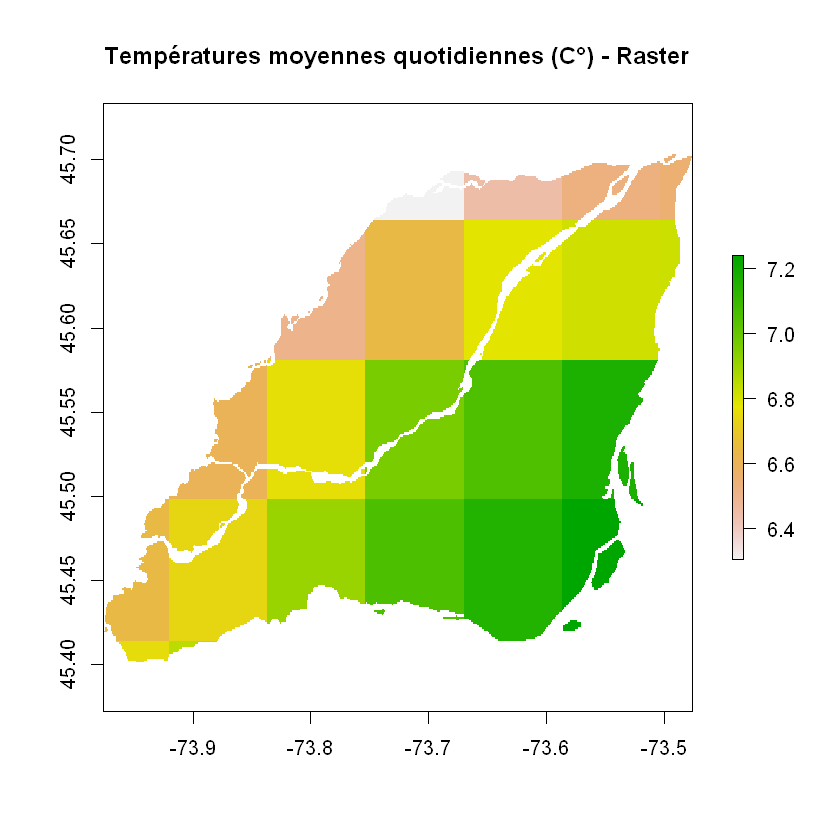

In [23]:
# Transformer les vecteurs data en raster
extent_c <- extent(climate_vector)
raster_grid <- raster::raster(extent_c, res=0.001)
raster_layer <- raster::rasterize(climate_vector, raster_grid, field="hist_1981_")

# Afficher le résultat
plot(raster_layer, main="Températures moyennes quotidiennes (C°) - Raster", ext=extent_c)
box()

Il est important de fixer une résolution plus précise que le shapefile original pour éviter les problèmes concernant la position de la grille et la taille des blocs. Il ne faut pas non plus que les cellules soient trop précises pour éviter qu'on obtienne beaucoup de valeurs manquantes après extraction.

Maintenant que nous avons nos données raster, il ne nous reste plus qu'à les lier avec nos données d'occurrence : 

In [24]:
# Dataframe d'affichage (pour ne pas changer notre dataset original)
species_data_dummy <- species_data 

# Extraire la variable climatique pour chaque point d'occurrence
climate_variable <- raster::extract(raster_layer, species_data, method="bilinear")
    
# Ajouter la nouvelle feature dans le dataset
species_data_dummy@data["mean_temp_year"] <- climate_variable

# Afficher le dataset lié 
head(species_data_dummy@data)

Present,mean_temp_year
1,6.962
1,7.052
1,7.052
1,7.052
1,6.962
1,6.962


Parfait ! Maintenant, il s'agira de répéter le processus pour toutes les variables environnementales : 

In [25]:
# Lister les fichiers shapefile du climat de Montreal
filenames <- list.files("data/ouranos/", pattern="*.shp", full.names=TRUE)

# (Optionel) Préparer l'affichage des graphes
# num_files <- length(filenames)
# options(repr.plot.height = 4 * num_files / 2)
# par(mfrow=c(num_files / 2, 2), mar=rep(0, 4))

# Dataset complet 
species_data_final <- species_data

# Pour chaque fichier...
for(filename in filenames){
    # Charger le fichier en mémoire
    climate_vector <- shapefile(filename)
    
    # Stocker le nom de la variable (nom du ficher shp)
    variable_name <- strsplit(filename, '/')[[1]]
    variable_name <- strsplit(variable_name[length(variable_name)], '.shp')[[1]]
    
    # Transformer les données vecteurs en raster
    extent <- extent(climate_vector)
    raster_grid <- raster::raster(extent, res=0.001)
    raster_layer <- raster::rasterize(climate_vector, raster_grid, field="hist_1981_")
    
    # (Optionel) Afficher les raster layers dans un graphe 
    # plot(raster_layer, ext=extent(climate_vector), main=strsplit(filename, '/')[-1])
    # box()
    
    # Extraire la variable climatique pour chaque point d'occurrence
    climate_variable <- raster::extract(raster_layer, species_data_final, col=variable_name, method="simple")
    
    # Ajouter la nouvelle feature dans le dataset
    species_data_final@data[variable_name] <- climate_variable
}

In [26]:
# Afficher le dataset complet 
head(species_data_final)

Present,avg_max_temp_spring,avg_min_temp_spring,avg_min_temp_winter,frost_index,max_precip_five_days,max_precip_five_days_apr_sep,max_temp_automn,max_temp_summer,max_temp_winter,max_temp_year,mean_temp_automn,mean_temp_spring,mean_temp_summer,mean_temp_winter,mean_temp_year,min_temp_automn,min_temp_summer,min_temp_year,num_days_heatwave_class_1,num_days_heatwave_class_2,num_days_heatwave_class_3,num_days_more_than_30deg,num_frost_defrost_automn,num_frost_defrost_spring,num_frost_defrost_summer,num_frost_defrost_winter,num_frost_defrost_year,num_heatwave_class_1,num_heatwave_class_2,num_heatwave_class_3,total_liquid_precip_automn,total_liquid_precip_spring,total_liquid_precip_summer,total_liquid_precip_winter,total_liquid_precip_year,total_precip_automn,total_precip_spring,total_precip_summer,total_precip_winter,total_precip_year,total_solid_precip_automn,total_solid_precip_spring,total_solid_precip_summer,total_solid_precip_winter,total_solid_precip_year
1,10.885,1.321,-11.670,843.096,72.099,65.098,12.85,25.452,-3.367,11.580,8.642,6.099,20.258,-7.535,6.962,4.477,15.064,2.403,0.133,1.600,2.333,11.3,18.633,26.300,0,26.433,70.067,0.033,0.4,0.667,257.282,199.597,278.740,77.053,815.008,268.825,228.657,228.657,218.756,1002.137,11.543,28.915,0,139.916,178.332
1,10.842,1.520,-11.293,821.741,72.926,66.373,12.78,25.394,-3.310,11.553,8.678,6.174,20.290,-7.317,7.052,4.623,15.186,2.608,0.167,1.533,2.267,11.1,18.000,25.433,0,26.367,67.933,0.033,0.4,0.633,260.900,205.388,284.364,78.559,833.742,272.697,233.462,233.462,222.859,1020.272,11.796,29.626,0,139.154,179.573
1,10.842,1.520,-11.293,821.741,72.926,66.373,12.78,25.394,-3.310,11.553,8.678,6.174,20.290,-7.317,7.052,4.623,15.186,2.608,0.167,1.533,2.267,11.1,18.000,25.433,0,26.367,67.933,0.033,0.4,0.633,260.900,205.388,284.364,78.559,833.742,272.697,233.462,233.462,222.859,1020.272,11.796,29.626,0,139.154,179.573
1,10.842,1.520,-11.293,821.741,72.926,66.373,12.78,25.394,-3.310,11.553,8.678,6.174,20.290,-7.317,7.052,4.623,15.186,2.608,0.167,1.533,2.267,11.1,18.000,25.433,0,26.367,67.933,0.033,0.4,0.633,260.900,205.388,284.364,78.559,833.742,272.697,233.462,233.462,222.859,1020.272,11.796,29.626,0,139.154,179.573
1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [27]:
summary(species_data_final@data)

    Present       avg_max_temp_spring avg_min_temp_spring avg_min_temp_winter
 Min.   :0.0000   Min.   :10.71       Min.   :0.568       Min.   :-12.89     
 1st Qu.:0.0000   1st Qu.:10.84       1st Qu.:1.321       1st Qu.:-11.67     
 Median :1.0000   Median :10.88       Median :1.520       Median :-11.29     
 Mean   :0.7439   Mean   :10.90       Mean   :1.411       Mean   :-11.46     
 3rd Qu.:1.0000   3rd Qu.:10.92       3rd Qu.:1.626       3rd Qu.:-11.09     
 Max.   :1.0000   Max.   :11.08       Max.   :1.633       Max.   :-11.04     
                  NA's   :2240        NA's   :2240        NA's   :2240       
  frost_index    max_precip_five_days max_precip_five_days_apr_sep
 Min.   :795.9   Min.   :69.49        Min.   :63.75               
 1st Qu.:802.8   1st Qu.:72.10        1st Qu.:65.14               
 Median :821.7   Median :72.20        Median :65.67               
 Mean   :828.8   Mean   :72.41        Mean   :65.71               
 3rd Qu.:843.1   3rd Qu.:72.93        3rd

#### 2.3.1 - Problèmes liées aux données d'Ouranos  :

On remarque dans notre dataset quelques points inquiétants : 
- Il y a beaucoup de valeurs manquantes.
- Il y a quelques variables qui ont 0 de variance (elles ne changent jamais, ex : total_solid_precip_summer).
- Il y a une très grosse redondance dans les données.

Pour les valeurs manquantes, elles sont probablemenet dûes aux points d'absences qui dépassent de l'extent du raster layer à cause de la différence entre la carte des limites administratives et la carte des données climatiques d'Ouranos. Pour le besoin de l'étude, on va juste les éliminer. Même chose pour les variables qui ont 0 de variance. 

In [28]:
# Enlever les valeurs manquantes
species_data_final@data <- na.omit(species_data_final@data) 

# Enlever les variables qui ont 0 de variance
zero_variance_variables <- which(apply(species_data_final@data, 2, var) == 0)
species_data_final@data <- species_data_final@data[ -as.numeric(zero_variance_variables)]

Le plus inquiétant par contre c'est la redondance des données, qui peut être soit liées aux correlations entre les attributs, ou aux corrélations entre les enregistrements.

Les attributs corréllés entre eux n'apportent pas d'information supplémentaires. Pour les faire ressortir nous devons utiliser une matrice de correlation. 

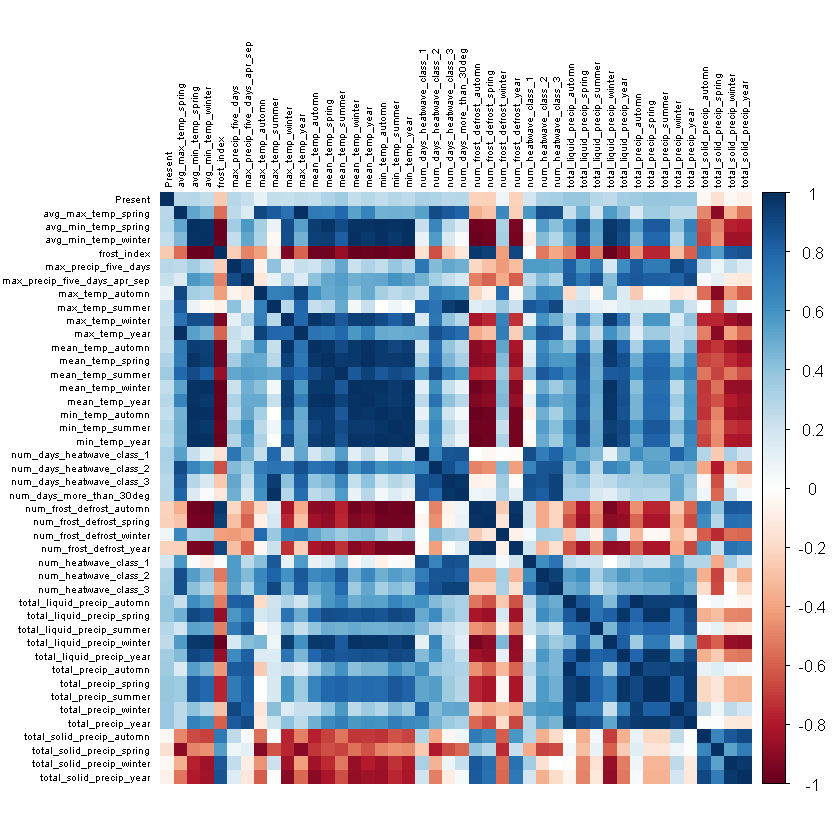

In [29]:
# Afficher la matrice de corrélation
cor_matrix <- cor(species_data_final@data)
corrplot(cor_matrix, method="color", tl.cex=.5, tl.col="black")

On peut remarquer d'après la matrice que les attributs sont hautement corrélés (positivement ou négativement). 

Pour régler ce problème en général, on supprime les attributs dont la valeur absolue de corrélation dépasse un certain coefficient de Pearson (coefficient de corrélation). Avant de choisir notre coefficient se, faisons d'abord des statistiques simples montrant le nombre d'attributs supprimés en prenant en considération des seuils différents : 

In [30]:
# Eliminer le triangle supérieur de la matrice de correlation (car elle est symetrique)
cor_matrix[upper.tri(cor_matrix)] <- 0

# Fixer les valeurs dans la diagonale car les variables avec elles-mêmes ont un coefficient de 1
diag(cor_matrix) <- 0
                                                                     
# Faire des statistiques sur la corrélation des attributs
thresholds <- c(0.7, 0.8, 0.9, 0.99)
for (threshold in thresholds) {
    # Créer un dataset avec les attributs corréllés supprimés
    len_before_cleaning <- length(species_data_final@data)
    cleaned_dataset <- species_data_final@data[, !apply(cor_matrix, 2, function(x) any(abs(x) > threshold))]
    len_after_cleaning <- length(cleaned_dataset)
    
    # Afficher le nombre d'attributs supprimés dans ce nouveau dataset
    print(paste("Coefficient de Pearson (valeur absolue) : ", threshold, 
                " - Nombre d'attributs supprimés :", len_before_cleaning - len_after_cleaning, sep=""))
}

[1] "Coefficient de Pearson (valeur absolue) : 0.7 - Nombre d'attributs supprimés :39"
[1] "Coefficient de Pearson (valeur absolue) : 0.8 - Nombre d'attributs supprimés :37"
[1] "Coefficient de Pearson (valeur absolue) : 0.9 - Nombre d'attributs supprimés :31"
[1] "Coefficient de Pearson (valeur absolue) : 0.99 - Nombre d'attributs supprimés :9"


Ce résultat renforce nos inquiétudes, plus de 37 attributs sont redondants (0.8 est une valeur considérée assez conséquente). Nous allons quand même continuer l'entrainement avec un dataset filtré avec un coefficient de Pearson à **0.8**.

In [31]:
species_data_final@data <- species_data_final@data[, !apply(cor_matrix, 2, function(x) any(abs(x) > 0.8))]

Passons maintenant au deuxième type de redondance, qui est ici bien plus inquiétant : La redondance des enregistrements. Tout d'abord, visualisons le nombre de données uniques dans notre jeu de données : 

In [32]:
# Compter le nombre d'enregistrements uniques dans le dataset
print(paste("Nombre d'enregistrements uniques en incluant les classes :", count(species_data_final@data %>% distinct())$n))

# Compter le nombre d'enregistrements sans la valeur cible 
print(paste("Nombre d'enregistrements uniques sans les classes :",
      count(species_data_final@data[2:length(species_data_final@data)] %>% distinct())$n))

# Compter le nombre d'enregistrements par classes
print("==== Nombre d'enregistrements uniques par classe ====")
print(paste("Present = 1 :", count(species_data_final@data[species_data_final@data$Present == 1, ] %>% distinct())$n))
print(paste("Present = 0 :", count(species_data_final@data[species_data_final@data$Present == 0, ] %>% distinct())$n))

[1] "Nombre d'enregistrements uniques en incluant les classes : 34"
[1] "Nombre d'enregistrements uniques sans les classes : 18"
[1] "==== Nombre d'enregistrements uniques par classe ===="
[1] "Present = 1 : 16"
[1] "Present = 0 : 18"


On remarque qu'on n'a que 19 enregistrements uniques distribués sur les deux valeurs de la classe cible (Present). Il n'y a en tout que 2 lignes différentes entre les enregistrements de présence et les enregistrements d'absence.

Cette redondance est très probablement dûe à l'imprécision des données d'Ouranos (60km² environ) qui donne des cellules très grosses. C'est un problème, car les données ne sont pas discriminantes (pas de différence entre les classes), l'algorithme de Machine Learning ne pourra pas donc trouver des relations pertinentes.

## 3. Entrainement des modèles
Dans ce projet, il sera question d'utiliser des algorithmes de Machine Learning, à savoir le **Random Forest** et **MAXENT**.

### 3.1 - Séparation des données
La séparation des données de test se fera à l'aide de la technique dite de la **Block Cross Validation**.

La block cross validation est une technique de séparation des données qui consiste à prendre en considération la position des données dans l'espace (ou le temps).

Par exemple, une stratégie de block cross validation consiste à séparer l'espace en blocs de même taille à la manière d'une grille, chaque bloc sera alors numéroté de 1 jusqu'à k (le nombre de *folds*), puis les blocs ayant le même numéro seront regroupé dans un *fold*. Le but de cette stratégie est de prendre nos données à partir d'endroits relativement eloignés, comme l'illustre cette figure : 

<img src="https://besjournals.onlinelibrary.wiley.com/cms/asset/58e88b81-cd83-44b0-b6ed-f4bafd1c9f45/mee313107-fig-0002-m.png
          "/>

Ces techniques de validation croisée sont implémentés dans le package **blockCV** du langage R. 

Warning message in rasterNet(rasterLayer[[1]], resolution = theRange, xbin = cols, :
"The input layer has no CRS defined. Based on the extent of the input map it is assumed to have an un-projected reference system"Warning message in spatialBlock(speciesData = species_data, species = "Present", :
 Progress [===================================================] 100% in 11m


The best folds was in iteration 4:
  train_0 train_1 test_0 test_1
1    8954   27688   2395   5359
2    9255   27087   2094   5960
3    8981   25779   2368   7268
4    9085   27149   2264   5898
5    9121   24485   2228   8562


[1] "SpatialBlock"

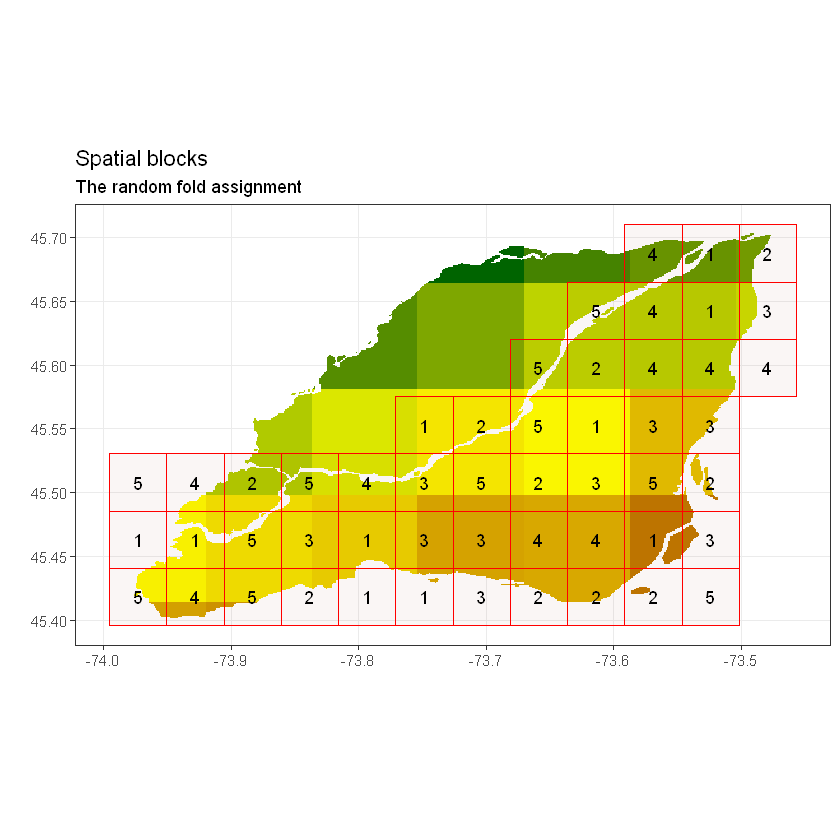

In [33]:
# Stratégie de block spatiaux 
folds <- spatialBlock(speciesData = species_data, # Données d'occurrence
                   species = "Present", # La colonne cible (la classe)
                   theRange = 5000, # Taille des blocks (en m)
                   k = 5, # Nombre de folds
                   selection = "random", # Selection aléatoires de blocs 
                   rasterLayer = raster_layer, # a raster for background (optional)
                   iteration = 100, # Nombre d'itérations avant de trouver les blocs optimaux (bonne distribution des données)
                   biomod2Format = FALSE)
folds

Maintenant la séparation faite, nous pouvons entrainer notre premier modèle : le Random Forest : 

In [54]:
# Métriques 
# --- Entrainement ----
train_accuracy <- numeric(length(folds$folds))
train_kappa <- numeric(length(folds$folds))
train_auc <- numeric(length(folds$folds))
train_f1_measure <- numeric(length(folds$folds))
train_no_information_rate <- numeric(length(folds$folds))

# --- Test ----
accuracy <- numeric(length(folds$folds))
kappa <- numeric(length(folds$folds))
auc <- numeric(length(folds$folds))
f1_measure <- numeric(length(folds$folds))
no_information_rate <- numeric(length(folds$folds))

# Modèles et predictions
rf <- vector("list", (length(folds$folds)))
# predictions <- vector("list", (length(folds$folds)))

# Pour chaque fold...
for (i in 1:length(folds$folds)){
    fold <- folds$folds[[i]]
    
    # Extraire les données d'entrainement
    xy_train <- species_data_final[fold[1][[1]], ]
    xy_train <- na.omit(xy_train@data)
    y_train <- xy_train$Present
    x_train <- xy_train[2:length(colnames(xy_train))]
    
    # Extraire les données de test
    xy_test <- species_data_final[fold[2][[1]], ]
    xy_test <- na.omit(xy_test@data)
    
    # Entrainer le modèle Random Forest (paramètres par défault)
    sdm_rf <- randomForest(x_train, as.factor(y_train))
    rf[[i]] <- sdm_rf
    
    # ===== METRIQUES ======
    # Nous utilisons la fonction confusionMatrix de Caret 
    # pour obtenir les metriques suivantes : accuracy, kappa et no_information_rate
    
    # ------ ENTRAINEMENT ------
    prediction <- predict(sdm_rf, xy_train)
    
    # Accuracy / Kappa / NIR / F-Measure
    cm <- confusionMatrix(as.factor(xy_train$Present), as.factor(prediction))
    overall <- cm[3][[1]]
    train_accuracy[i] <- overall[1]
    train_kappa[i] <- overall[2]
    train_no_information_rate[i] <- overall[5]
    
    byClass <- cm[4][[1]]
    train_f1_measure[i] <- byClass[7]
    
    # AUC
    rf_p_train <- predict(sdm_rf, type="prob", newdata=xy_train)[,2]
    rf_pr_train <- prediction(rf_p_train, as.factor(xy_train$Present))
    train_auc[i] <- performance(rf_pr_train, measure = "auc")@y.values[[1]] 
    
    # ----- TEST ------
    prediction <- predict(sdm_rf, xy_test)
    
    cm <- confusionMatrix(as.factor(xy_test$Present), as.factor(prediction))
    overall <- cm[3][[1]]
    accuracy[i] <- overall[1]
    kappa[i] <- overall[2]
    no_information_rate[i] <- overall[5]
    
    byClass <- cm[4][[1]]
    f1_measure[i] <- byClass[7]
    
    # Calculer l'AUC
    rf_p_train <- predict(sdm_rf, type="prob", newdata=xy_test)[,2]
    rf_pr_train <- prediction(rf_p_train, as.factor(xy_test$Present))
    auc[i] <- performance(rf_pr_train, measure = "auc")@y.values[[1]] 
}

In [53]:
# Data frame contenant les statistiques de nos modèles
model_stats = data.frame(
    Train_Accuracy=train_accuracy, 
    Train_Kappa=train_kappa, 
    Train_NIR=train_no_information_rate,
    Train_Auc=train_auc, 
    Train_F1_Measure=train_f1_measure,
    Accuracy=accuracy, 
    Kappa=kappa, 
    No_Information_Rate=no_information_rate,
    Auc=auc,
    F1_Measure=f1_measure
)

cat('\n===== STATISTIQUES DES MODELES =====\n')
head(model_stats)

# Afficher les moyennes des metriques
cat('\n===== MOYENNES =====\n')

cat('\n--- Entrainement ----\n\n')
print(paste('Moyenne accuracy (entrainement): ', as.character(format(round(mean(model_stats$Train_Accuracy), 4), nsmall = 4)), 
            "%", sep=""))
print(paste('Moyenne kappa (entrainement) : ', as.character(format(round(mean(model_stats$Train_Kappa), 4), nsmall = 4)), 
            "%", sep=""))
print(paste('Moyenne AUC (entrainement): ', as.character(format(round(mean(model_stats$Train_Auc), 4), nsmall = 4)), 
            "%", sep=""))
print(paste('Moyenne NIR (entrainement): ', as.character(format(round(mean(model_stats$Train_NIR), 4), 
                                                                nsmall = 4)), "%", sep=""))

cat('\n--- Test ----\n\n')
print(paste('Moyenne accuracy (test): ', as.character(format(round(mean(model_stats$Accuracy), 4), nsmall = 4)), "%", sep=""))
print(paste('Moyenne kappa (test) : ', as.character(format(round(mean(model_stats$Kappa), 4), nsmall = 4)), "%", sep=""))
print(paste('Moyenne AUC (test): ', as.character(format(round(mean(model_stats$Auc), 4), nsmall = 4)), "%", sep=""))
print(paste('Moyenne NIR (test): ', as.character(format(round(mean(model_stats$No_Information_Rate), 4), nsmall = 4)), 
            "%", sep=""))

# Statistiques complètes
cat("\n\n===== STATISTIQUES COMPLETES =====\n")
summary(model_stats)


===== STATISTIQUES DES MODELES =====


Train_Accuracy,Train_Kappa,Train_NIR,Train_Auc,Train_F1_Measure,Accuracy,Kappa,No_Information_Rate,Auc,F1_Measure
0.8545872,0.4508777,0.9065940,0.6873633,0.5219604,0.8184565,0.4263959,0.8889041,0.6749604,0.5161054
0.8469716,0.4417604,0.9015149,0.6779797,0.5175783,0.8545621,0.4684052,0.9126849,0.6835826,0.5353409
0.8446949,0.4426392,0.9006847,0.6782311,0.5193173,0.8615116,0.4609848,0.9138270,0.6812214,0.5265123
0.8509995,0.4459533,0.9065260,0.6782124,0.5182262,0.8365608,0.4477459,0.8902659,0.6829399,0.5307635
0.8439179,0.4513683,0.9021148,0.6806499,0.5269073,0.8619789,0.4280009,0.9079215,0.6725169,0.4980654



===== MOYENNES =====

--- Entrainement ----

[1] "Moyenne accuracy (entrainement): 0.8482%"
[1] "Moyenne kappa (entrainement) : 0.4465%"
[1] "Moyenne AUC (entrainement): 0.6805%"
[1] "Moyenne NIR (entrainement): 0.9035%"

--- Test ----

[1] "Moyenne accuracy (test): 0.8466%"
[1] "Moyenne kappa (test) : 0.4463%"
[1] "Moyenne AUC (test): 0.6790%"
[1] "Moyenne NIR (test): 0.9027%"


===== STATISTIQUES COMPLETES =====


 Train_Accuracy    Train_Kappa       Train_NIR        Train_Auc     
 Min.   :0.8439   Min.   :0.4418   Min.   :0.9007   Min.   :0.6780  
 1st Qu.:0.8447   1st Qu.:0.4426   1st Qu.:0.9015   1st Qu.:0.6782  
 Median :0.8470   Median :0.4460   Median :0.9021   Median :0.6782  
 Mean   :0.8482   Mean   :0.4465   Mean   :0.9035   Mean   :0.6805  
 3rd Qu.:0.8510   3rd Qu.:0.4509   3rd Qu.:0.9065   3rd Qu.:0.6806  
 Max.   :0.8546   Max.   :0.4514   Max.   :0.9066   Max.   :0.6874  
 Train_F1_Measure    Accuracy          Kappa        No_Information_Rate
 Min.   :0.5176   Min.   :0.8185   Min.   :0.4264   Min.   :0.8889     
 1st Qu.:0.5182   1st Qu.:0.8366   1st Qu.:0.4280   1st Qu.:0.8903     
 Median :0.5193   Median :0.8546   Median :0.4477   Median :0.9079     
 Mean   :0.5208   Mean   :0.8466   Mean   :0.4463   Mean   :0.9027     
 3rd Qu.:0.5220   3rd Qu.:0.8615   3rd Qu.:0.4610   3rd Qu.:0.9127     
 Max.   :0.5269   Max.   :0.8620   Max.   :0.4684   Max.   :0.9138     
      Auc    